In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle

In [2]:
data_dir = '../../../data/'

In [10]:
subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

n_repeats = 3
rois = 3
#threshold for voxels (based on split-half reliability)
thresh = 0.2

In [12]:
reliability = []
for sidx, sid in enumerate(subjid):
    
    sh_dir = '../../../local_data/freesurfer/subj' + sid + '/rh_split_half.mat'
    sh = scipy.io.loadmat(sh_dir)
    
    reliability.append(sh['mean'])
rh_streams = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj'+ sid +'/label/rh.streams.mgz')
    rh_streams.append(mgh_file.get_fdata()[:,0,0])
# let's organize by ROI 
sh_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]
total_vox = np.zeros((len(subjid), len(ROI_names)-1))

for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1):       
        sh_by_ROI[sidx][roi_idx]=reliability[sidx][:,rh_streams[sidx] == roi_idx+1]
        total_vox[sidx,roi_idx] = len(sh_by_ROI[sidx][roi_idx][0])


In [14]:
rsm_corr_within_ROI = np.zeros((len(subjid), rois,n_repeats))
rsm_corr_between_ROI = np.zeros((len(subjid), 6))

r1_trial_order = [0, 0, 1, 1, 2, 2]
r2_trial_order = [1, 2, 0, 2, 0, 1]

In [15]:
for sidx, sid in enumerate(subjid):
    #load data
    save_file = '../../../local_data/processed/subj' + sid +'_all_HVA_zscored_betas.data'

    with open(save_file, 'rb') as filehandle:
        betas_by_repeat_ventral, betas_by_repeat_lateral, betas_by_repeat_parietal= pickle.load(filehandle)
    
    for vox in range(len(sh_by_ROI[sidx][4][0])):
        if sh_by_ROI[sidx][4][0][vox] < thresh:
            betas_by_repeat_ventral[0][:,vox]=np.nan
            betas_by_repeat_ventral[1][:,vox]=np.nan
            betas_by_repeat_ventral[2][:,vox]=np.nan  
    for vox in range(len(sh_by_ROI[sidx][5][0])):
        if sh_by_ROI[sidx][5][0][vox] < thresh:
            betas_by_repeat_lateral[0][:,vox]=np.nan
            betas_by_repeat_lateral[1][:,vox]=np.nan
            betas_by_repeat_lateral[2][:,vox]=np.nan  
    for vox in range(len(sh_by_ROI[sidx][6][0])):
        if sh_by_ROI[sidx][6][0][vox] < thresh:
            betas_by_repeat_parietal[0][:,vox]=np.nan
            betas_by_repeat_parietal[1][:,vox]=np.nan
            betas_by_repeat_parietal[2][:,vox]=np.nan  
    

    for r in range(n_repeats):
        temp = betas_by_repeat_ventral[r]
        trimmed = temp[:,~np.all(np.isnan(temp), axis=0)]
        betas_by_repeat_ventral[r] = trimmed
        
        temp = betas_by_repeat_lateral[r]
        trimmed = temp[:,~np.all(np.isnan(temp), axis=0)]
        betas_by_repeat_lateral[r] = trimmed
        
        temp = betas_by_repeat_parietal[r]
        trimmed = temp[:,~np.all(np.isnan(temp), axis=0)]
        betas_by_repeat_parietal[r] = trimmed
                
    tril_flat_shape = int((betas_by_repeat_ventral[0].shape[0]**2/2) - (betas_by_repeat_ventral[0].shape[0]/2))
    flat_rsm = np.zeros((rois, tril_flat_shape, n_repeats))
    rsm = np.zeros((rois,n_repeats,betas_by_repeat_ventral[0].shape[0],betas_by_repeat_ventral[0].shape[0]))
    
    for ridx in range(rois):
    
        if ridx == 0:
            betas = betas_by_repeat_ventral
        elif ridx == 1:
            betas = betas_by_repeat_lateral
        else:
            betas = betas_by_repeat_parietal

        for r in range(n_repeats):
            rsm[ridx,r,:,:] = np.corrcoef(betas[r])

            lower = np.tril(rsm[ridx,r,:,:], -1).T.ravel()
            flat_rsm[ridx,:,r] = lower[lower != 0]
    
    #within ROI
    for roi_idx in range(rois):

        rsm_corr = [np.absolute(stats.pearsonr(flat_rsm[roi_idx,:,0],flat_rsm[roi_idx,:,1])[0]),
                    np.absolute(stats.pearsonr(flat_rsm[roi_idx,:,0],flat_rsm[roi_idx,:,2])[0]),
                    np.absolute(stats.pearsonr(flat_rsm[roi_idx,:,1],flat_rsm[roi_idx,:,2])[0])]

        rsm_corr_within_ROI[sidx,roi_idx,:] = rsm_corr
    
    #between ROI

    roi_1 = 0 #ventral
    roi_2 = 1 #lateral

    for r in range(6):
        rsm_corr_between_ROI[sidx, r] = np.absolute(stats.pearsonr(flat_rsm[roi_1,:,r1_trial_order[r]],
                                                                   flat_rsm[roi_2,:,r2_trial_order[r]])[0])


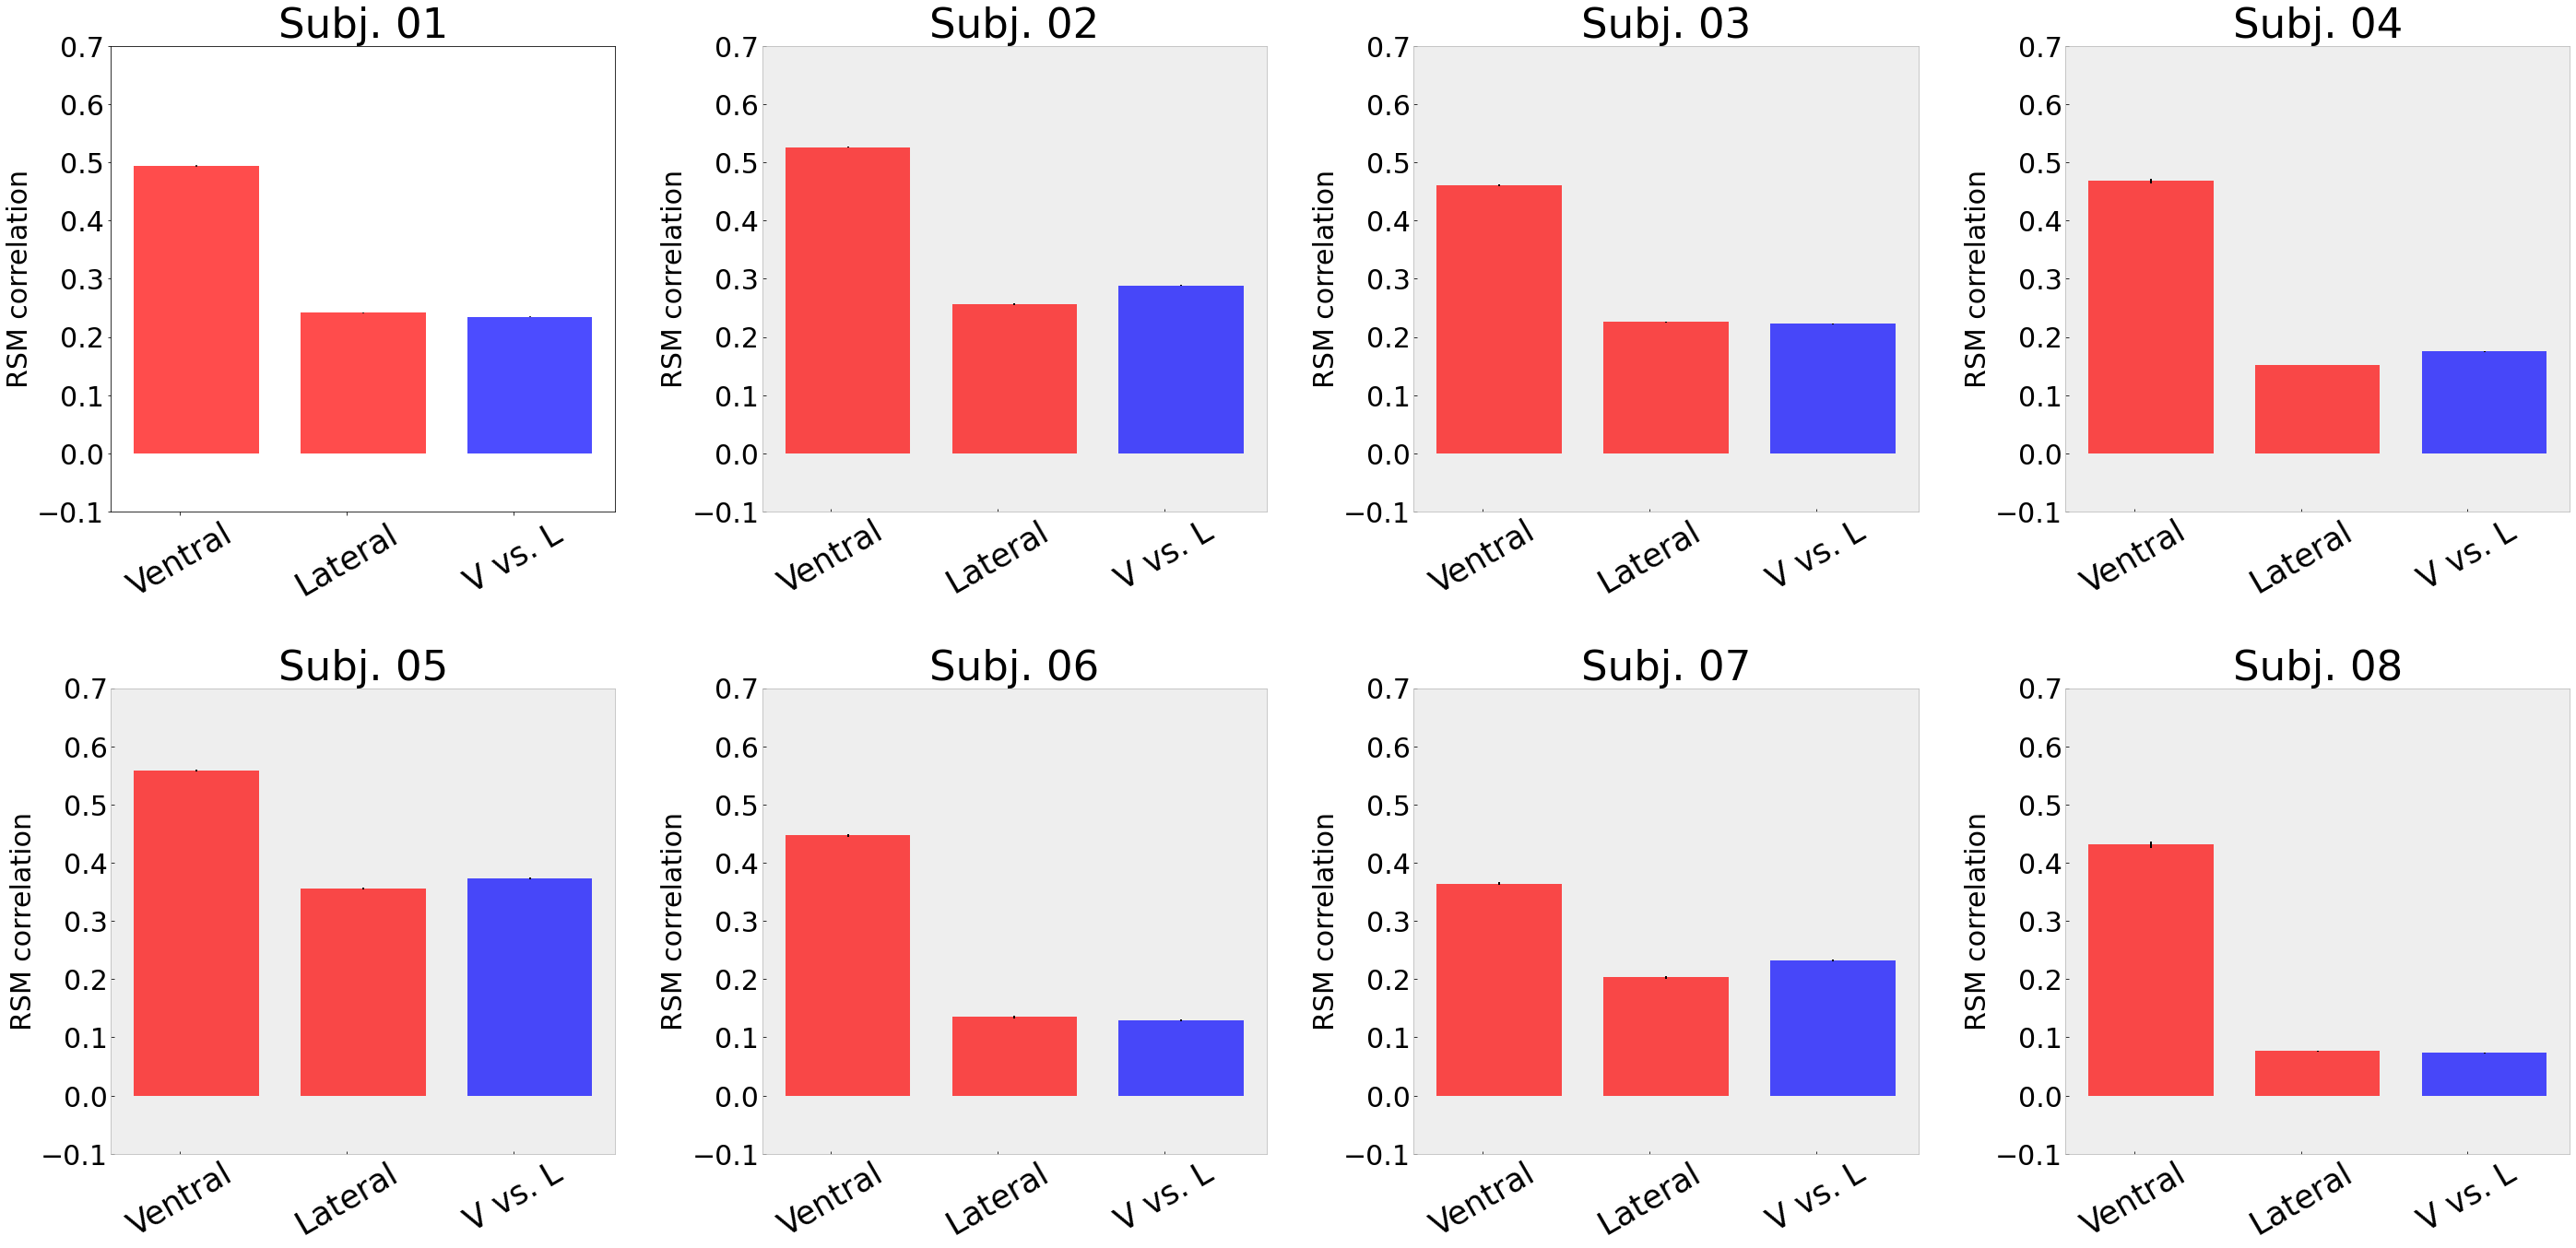

In [16]:

plt.figure(figsize=(40, 20))

for sidx, sid in enumerate(subjid):

    plt.subplot(2, 4, sidx+1)
        
    data = [np.mean(rsm_corr_within_ROI[sidx,0,:]), 
            np.mean(rsm_corr_within_ROI[sidx,1,:]),
            np.mean(rsm_corr_between_ROI[sidx,:])]
    
    error = [stats.sem(rsm_corr_within_ROI[sidx,0,:]), 
             stats.sem(rsm_corr_within_ROI[sidx,1,:]),
             stats.sem(rsm_corr_between_ROI[sidx,:])]
    
    
    xlocations = np.array(range(3))+.1
    width = 0.75
    plt.bar(xlocations, data, yerr=error, width=width, alpha = 0.7, color = ['r', 'r', 'b'])
    
     #plt.hist(avg_corrvals[np.where(rh_streams == r)[0]],bins=50,alpha=0.7, rwidth=1, color = c[r])
    
    #plt.xlim(-0.1,1)
    #plt.xticks([fontsize=20])
    plt.xticks(np.arange(0, 3), ['Ventral', 'Lateral', 'V vs. L'], rotation=30, fontsize=35);
    
    plt.ylim(-0.1,0.7)
    plt.yticks(fontsize=30)
    
    plt.ylabel('RSM correlation',size = 30)
    
    title_string = "Subj. "
    title_string += sid
    plt.title(title_string,size = 45)
    
    plt.style.use("bmh")
    plt.grid(False)
    
    plt.tight_layout(pad=5)
    
plt.savefig('../../../results/figures/RSMcorr_allImgs_ventralVSlateral_voxThresh' + str(int(thresh*100)) + '_abs_zscore.png')
